# SBERT Fine-Tuning Constrastive Learning

## 0. Dependencies, model and datasets

In [4]:
#load revelant packages
import pandas as pd
import numpy
import torch
from datasets import load_dataset, DatasetDict, Features, Value
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

from sentence_transformers import (
    SentenceTransformer,
    SentenceTransformerTrainer,
    SentenceTransformerTrainingArguments
)
from sentence_transformers.losses import BatchSemiHardTripletLoss
from sentence_transformers.evaluation import TripletEvaluator
from transformers import EarlyStoppingCallback

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [2]:
#load the SBERT model and two datasets
model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2").to(device)

# need triplet structure for evalution
triplet_dataset = load_dataset('csv', data_files={
    'validation': 'triplets_val.csv',
    'train': 'triplets_train.csv',
    'test': 'triplets_test.csv'
})

print(triplet_dataset)

# required for loss function input
label_dataset = load_dataset('csv', data_files={
    'validation': 'label_val.csv',
    'train': 'label_train.csv',
    'test': 'label_test.csv'
})

print(label_dataset)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

DatasetDict({
    validation: Dataset({
        features: ['anchor', 'positive', 'negative'],
        num_rows: 1423
    })
    train: Dataset({
        features: ['anchor', 'positive', 'negative'],
        num_rows: 6643
    })
    test: Dataset({
        features: ['anchor', 'positive', 'negative'],
        num_rows: 1424
    })
})


Generating validation split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

DatasetDict({
    validation: Dataset({
        features: ['lyric', 'label'],
        num_rows: 1423
    })
    train: Dataset({
        features: ['lyric', 'label'],
        num_rows: 6643
    })
    test: Dataset({
        features: ['lyric', 'label'],
        num_rows: 1424
    })
})


In [3]:
from collections import Counter

# Function to count labels
def count_labels(dataset_split, split_name):
    label_counts = Counter(dataset_split['label'])
    print(f"\nLabel distribution in '{split_name}':")
    for label, count in sorted(label_counts.items()):
        print(f"  Label '{label}': {count} samples")
    return label_counts

# Apply to all splits
train_counts = count_labels(label_dataset['train'], 'train')
val_counts = count_labels(label_dataset['validation'], 'validation')
test_counts = count_labels(label_dataset['test'], 'test')


Label distribution in 'train':
  Label '0': 1723 samples
  Label '1': 942 samples
  Label '2': 1724 samples
  Label '3': 360 samples
  Label '4': 777 samples
  Label '5': 1117 samples

Label distribution in 'validation':
  Label '0': 369 samples
  Label '1': 202 samples
  Label '2': 369 samples
  Label '3': 77 samples
  Label '4': 167 samples
  Label '5': 239 samples

Label distribution in 'test':
  Label '0': 369 samples
  Label '1': 202 samples
  Label '2': 370 samples
  Label '3': 77 samples
  Label '4': 166 samples
  Label '5': 240 samples


## 1. Model Finetuning/ Training
For more details refer to: https://www.sbert.net/docs/sentence_transformer/training_overview.html#training-overview

In [ ]:
#loss function
# We are using a variant of triplet loss;
# BatchSemiHardTripletLoss constructs all possible triplets during training, no manual triplet construction required
# Uses semihard negatives = negative examples are still allowed within in the margin but trivially easy negatives
# are not used.
# refer to https://sbert.net/docs/package_reference/sentence_transformer/losses.html#sentence_transformers.losses.BatchSemiHardTripletLoss

loss = BatchSemiHardTripletLoss(model, margin=0.3)

# training arguments
args = SentenceTransformerTrainingArguments(
    output_dir="models/finetuned",
    num_train_epochs=10,              #
    per_device_train_batch_size=64,  # these three arguments determine how many steps per epoch are made
    per_device_eval_batch_size=64,   # 256 batch size seems to be the upper limit for google collab
    optim= "adamw_torch", #Adam Optimizer
    learning_rate=2e-5,
    warmup_ratio=0.1, # fraction of steps were approaching learning rate slowly; eg. 0.1 = 10% of first steps for warmup
    lr_scheduler_type ='cosine',
    fp16=False,  # Set to False if you get an error that your GPU can't run on FP16
    bf16=False,  # Set to True if you have a GPU that supports BF16
    batch_sampler='default',
    seed=42,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2, #saves the last two checkpoints
    logging_steps=1, #logs train, val loss at every epoch
    report_to="none", # to avoid API key request
    load_best_model_at_end=True, # has to be true for early stopper to work
    metric_for_best_model = 'eval_val_cosine_accuracy', # metric for the evaluator cosine accuracy
    dataloader_pin_memory = False # will give warning message on CPU when True; Set to true if training on GPU and bigger datasets
)


#Initialize the evaluator for validation set
# triplet evaluator requires the triplet structure independent of train set structure
# NOTE: Ensure that training and test split occurs before constructing the validation and test set triplets
# uses cosine accuracy
# source: https://sbert.net/docs/package_reference/sentence_transformer/evaluation.html#sentence_transformers.evaluation.TripletEvaluator
val_evaluator = TripletEvaluator(
    anchors=list(triplet_dataset['validation']["anchor"]),
    positives=list(triplet_dataset['validation']["positive"]),
    negatives=list(triplet_dataset['validation']["negative"]),
    name="val"
)


# trainer
trainer = SentenceTransformerTrainer(
    model=model,
    args=args,
    train_dataset=label_dataset['train'],
    eval_dataset=label_dataset['validation'],
    evaluator=val_evaluator,
    loss=loss,
    callbacks = [EarlyStoppingCallback(early_stopping_patience=3, early_stopping_threshold=0.001)]
    # source for early stopper https://stackoverflow.com/questions/69087044/early-stopping-in-bert-trainer-instances
    #https://huggingface.co/docs/transformers/main/en/main_classes/callback#transformers.EarlyStoppingCallback
)

trainer.train()

#save
model.save_pretrained("models/finetuned/final")


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

Epoch,Training Loss,Validation Loss,Val Cosine Accuracy
1,0.253200,0.250428,0.698524
2,0.243000,0.245775,0.716796
3,0.195400,0.241090,0.725931
4,0.248000,0.240846,0.716093
5,0.164200,0.240199,0.723120
6,0.220700,0.241608,0.732256
7,0.101000,0.242442,0.723823
8,0.138900,0.242061,0.723120
9,0.217400,0.242559,0.712579


TrainOutput(global_step=936, training_loss=0.2259437596011493, metrics={'train_runtime': 598.6173, 'train_samples_per_second': 110.972, 'train_steps_per_second': 1.737, 'total_flos': 0.0, 'train_loss': 0.2259437596011493, 'epoch': 9.0})

In [ ]:
# extracting train and eval loss from the directory and plotting their curves
import json
with open('models/finetuned/checkpoint-936/trainer_state.json', 'r') as file: # pay attention here because early stopper changes checkpoint, maybe construct dynamic variable
    data = json.load(file)

df = pd.DataFrame(data['log_history'])
df = df[['epoch', 'loss', 'eval_loss','eval_val_cosine_accuracy']]
df = df.groupby('epoch').min() # groub by can reduce something really easily eg. get rid of NaN; val and cosine only at epochs not steps
df = df.dropna()
df

,loss,eval_loss,eval_val_cosine_accuracy
epoch,,,
1.0,0.2532,0.250428,0.698524
2.0,0.2430,0.245775,0.716796
3.0,0.1954,0.241090,0.725931
4.0,0.2480,0.240846,0.716093
5.0,0.1642,0.240199,0.723120
6.0,0.2207,0.241608,0.732256
7.0,0.1010,0.242442,0.723823
8.0,0.1389,0.242061,0.723120
9.0,0.2174,0.242559,0.712579


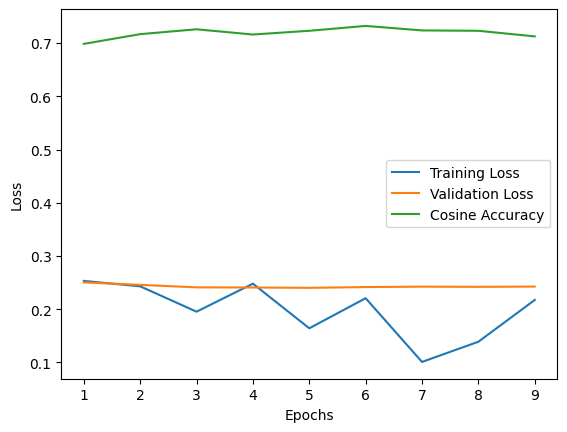

In [ ]:
# plot curves
import matplotlib.pyplot as plt
plt.plot(df['loss'], label='Training Loss')
plt.plot(df['eval_loss'], label='Validation Loss')
plt.plot(df['eval_val_cosine_accuracy'], label='Cosine Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## 2. Comparison base vs. finetuned

In [ ]:
#### cosine accuracy comparison on val set
#load models
base_model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2").to(device)
finetuned_model = SentenceTransformer("models/finetuned/final").to(device)

#calculate accuracy
results = val_evaluator(base_model)
print(val_evaluator.primary_metric)
print(results[val_evaluator.primary_metric])

f_results = val_evaluator(finetuned_model)
print(val_evaluator.primary_metric)
print(f_results[val_evaluator.primary_metric])

val_cosine_accuracy
0.601546049118042
val_cosine_accuracy
0.7322558164596558


In [ ]:
# intution for testing: The model was finetuned for genre, therefore a simple
# classfier should perform better with embeddings as input encoded by the
# finetuned model
# hyppothesis = embeddings finetuned for genre should lead to better performance in
# a genre classificiation task

# load datasets from before and the base
train = pd.read_csv('label_train.csv')
val = pd.read_csv('label_val.csv')

#encode embeddings
X_train_base = base_model.encode(train['lyric'], convert_to_numpy=True)
X_test_base  = base_model.encode(val['lyric'], convert_to_numpy=True)

#fine
X_train_fine = finetuned_model.encode(train['lyric'], convert_to_numpy=True)
X_test_fine  = finetuned_model.encode(val['lyric'], convert_to_numpy=True)

# scaling with standardscaler
scaler = StandardScaler()
#base
X_train_base = scaler.fit_transform(X_train_base)
X_test_base = scaler.transform(X_test_base)

#fine
X_train_fine = scaler.fit_transform(X_train_fine)
X_test_fine = scaler.transform(X_test_fine)

#labels can be used for both
y_train, y_test = train['label'], val['label']

# knn base embeddings
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_base, y_train)
y_pred_base = knn.predict(X_test_base)

#knn finetuned embeddings
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_fine, y_train)
y_pred_fine = knn.predict(X_test_fine)


#evalution and comparison
report_base = classification_report(y_test, y_pred_base)
print(report_base)
report_fine = classification_report(y_test, y_pred_fine)
print(report_fine)

              precision    recall  f1-score   support

           0       0.41      0.44      0.42       369
           1       0.25      0.21      0.23       202
           2       0.63      0.90      0.74       369
           3       0.37      0.09      0.15        77
           4       0.27      0.14      0.19       167
           5       0.56      0.54      0.55       239

    accuracy                           0.49      1423
   macro avg       0.42      0.39      0.38      1423
weighted avg       0.45      0.49      0.46      1423

              precision    recall  f1-score   support

           0       0.45      0.57      0.50       369
           1       0.42      0.30      0.35       202
           2       0.75      0.87      0.80       369
           3       0.46      0.08      0.13        77
           4       0.41      0.23      0.30       167
           5       0.64      0.75      0.69       239

    accuracy                           0.57      1423
   macro avg       0.52

## 3. Testing

In [8]:
#### Evaluating Performance on the test set

# Comparing perfomances on test set between finetuned and base model
#Initialize the evaluator
base_model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2").to(device)
finetuned_model = SentenceTransformer("content/models/finetuned/final").to(device)

test_evaluator = TripletEvaluator(
    anchors=list(triplet_dataset['test']['anchor']),
    positives=list(triplet_dataset['test']['positive']),
    negatives=list(triplet_dataset['test']['negative']),
    name="val"
)

results = test_evaluator(base_model)
print(test_evaluator.primary_metric)
print(results[test_evaluator.primary_metric])

f_results = test_evaluator(finetuned_model)
print(test_evaluator.primary_metric)
print(f_results[test_evaluator.primary_metric])

val_cosine_accuracy
0.5933988690376282
val_cosine_accuracy
0.7050561904907227


In [9]:
# intution for testing: The model was finetuned for genre, therefore a simple
# classfier should perform better with embeddings as input encoded by the
# finetuned model
# hyppothesis = embeddings finetuned for genre should lead to better performance in
# a genre classificiation task

# load datasets from before and the base
train = pd.read_csv('label_train.csv')
test = pd.read_csv('label_test.csv')

#encode embeddings
X_train_base = base_model.encode(train['lyric'], convert_to_numpy=True)
X_test_base  = base_model.encode(test['lyric'], convert_to_numpy=True)

#fine
X_train_fine = finetuned_model.encode(train['lyric'], convert_to_numpy=True)
X_test_fine  = finetuned_model.encode(test['lyric'], convert_to_numpy=True)

# scaling with standardscaler
scaler = StandardScaler()
#base
X_train_base = scaler.fit_transform(X_train_base)
X_test_base = scaler.transform(X_test_base)

#fine
X_train_fine = scaler.fit_transform(X_train_fine)
X_test_fine = scaler.transform(X_test_fine)

#labels can be used for both
y_train, y_test = train['label'], test['label']

# knn base embeddings
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_base, y_train)
y_pred_base = knn.predict(X_test_base)

#knn finetuned embeddings
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_fine, y_train)
y_pred_fine = knn.predict(X_test_fine)


#evalution and comparison
report_base = classification_report(y_test, y_pred_base)
print(report_base)
report_fine = classification_report(y_test, y_pred_fine)
print(report_fine)

              precision    recall  f1-score   support

           0       0.43      0.42      0.42       369
           1       0.31      0.25      0.28       202
           2       0.60      0.91      0.72       370
           3       0.53      0.13      0.21        77
           4       0.34      0.17      0.23       166
           5       0.52      0.50      0.51       240

    accuracy                           0.49      1424
   macro avg       0.45      0.40      0.39      1424
weighted avg       0.46      0.49      0.46      1424

              precision    recall  f1-score   support

           0       0.44      0.57      0.49       369
           1       0.37      0.24      0.29       202
           2       0.73      0.86      0.79       370
           3       0.69      0.12      0.20        77
           4       0.37      0.20      0.26       166
           5       0.67      0.75      0.71       240

    accuracy                           0.56      1424
   macro avg       0.54